# Quickstart

This quickstart is a [Jupyter](https://jupyter.org/) session showing some simple LibLET objects usage.

## Type 1 grammars and production graphs

Let's start defining a *monotonic* grammar for $a^nb^nc^n$

In [1]:
from liblet import Grammar

G = Grammar.from_string("""
S -> a b c
S -> a S Q
b Q c -> b b c c
c Q -> Q c
""", False)

G

Grammar(N={Q, S}, T={a, b, c}, P=(S -> a b c, S -> a S Q, b Q c -> b b c c, c Q -> Q c), S=S)

It can be convenient to show the productions as a table, with numbered rows.

In [2]:
from liblet import iter2table

iter2table(G.P)

It's now time to create a *derivation* of $a^2b^2c^2$

In [3]:
from liblet import Derivation

d = Derivation(G).step(1, 0).step(0, 1).step(3, 3).step(2, 2)
d

S -> a S Q -> a a b c Q -> a a b Q c -> a a b b c c

It can be quite illuminating to see the *production graph* for such derivation

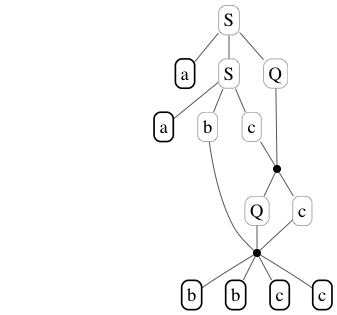

In [4]:
from liblet import ProductionGraph

ProductionGraph(d)

## Context-free grammars and ambiguity

Assume we want to experiment with an ambiguous grammar and look for two different leftmost derivation of the same sentence.

To this aim, let's consider the following grammar and a short derivation leading to and addition of three terminals

In [54]:
G = Grammar.from_string("""
E -> E + E
E -> E * E
E -> i
""")

d = Derivation(G).step(0, 0).step(0, 0)
d

E -> E + E -> E + E + E

What are the possible steps at this point? The `possible_steps` method comes in handy, here is a (numbered) table of pairs $(p, q)$ where $p$ is production number and $q$ the position of the nonterminal that can be substituted:

In [69]:
possible_steps = list(d.possible_steps())
iter2table(possible_steps)

If we look for just for leftmost derivations among the $(p, q)$s, we must keep just the $p$s corresponding to the $q$s equal to the minimum of the possible $q$ values. The following function can be used to such aim:

In [84]:
from operator import itemgetter

def filter_leftmost_prods(possible_steps):
    possible_steps = list(possible_steps)
    if possible_steps:
        min_q = min(possible_steps, key = itemgetter(1))[1]
        return map(itemgetter(0), filter(lambda ps: ps[1] == min_q, possible_steps))
    return tuple()

list(filter_leftmost_prods(possible_steps))

[0, 1, 2]

Now, using a `Queue` we can enumerate all the leftmost productions, we can have a fancy generator that returns a new derivation each time `next` is called on it:

In [108]:
from liblet import Queue

def derivation_generator(G):
    Q = Queue([Derivation(G)])
    while Q:
        derivation = Q.dequeue()
        if G.all_terminals(derivation.sentential_form()): 
            yield derivation
        for nprod in filter_leftmost_prods(derivation.possible_steps()):
            Q.enqueue(derivation.leftmost(nprod))

Let's collect the first 10 derivations

In [111]:
derivation = derivation_generator(G)
D = [next(derivation) for _ in range(10)]
iter2table(D)

As one can easily see, derivations 6 and 7 produce the same sentence `i + i * i` but evidently with two different leftmost derivations. We can give a look at the production graphs to better see what is happening.

In [112]:
from liblet import side_by_side

side_by_side(ProductionGraph(D[6]), ProductionGraph(D[7]))